In [2]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [3]:
session_info = {'date': "22_10_2024",
                'genotype_dir': 'EPG_jGCaMP8sRSET',
                'fly': 'fly2',
                'session': 'closed_loop-001',
                'fictrac_scan_num': 1,
                'fictrac_dat_file' : 'fictrac-20241022_155155.dat',
                'full_genotype': '', #'LexOpjGCaMP7b/+; UAS-TBH-RNAi/R60D05-LexA; LexOpCsChrimson::tdT/R18B05-Gal4',
                'ecl date': '10/17/2024',
                'notes': ''}


session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
# pkl_path = pathlib.PurePath(f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}/fly5_1_scan1.pkl")

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'])
                                         # fictrac_pkl_path=pkl_path)

In [4]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=True)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()



(291, 345)
[                                        ] | 0% Completed | 286.68 ms

<tifffile.TiffFile 'closed_loop-001…2_000002.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'closed_loop-001…2_000006.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'closed_loop-001…2_000006.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 


[########################################] | 100% Completed | 23.46 s


In [5]:
# pkl_path = None
# pp.fictrac_pkl_path = pathlib.PurePath(f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}/fly5_1_scan3.pkl")
# print(pkl_path)
print(pp.fictrac_pkl_path)

/media/mplitt/SSD_storage/fictrac_folder/EPG_jGCaMP8sRSET/22_10_2024/fly2/fly2_scan1.pkl


In [6]:
pp.align_fictrac()

In [7]:
nap = pp.open_napari()

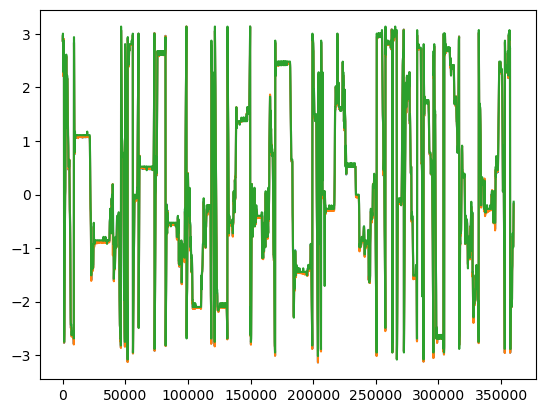

In [8]:
fig, ax = plt.subplots()
time = pp.fictrac_aligned['Time(ms)']
inds = slice(0,100000)
ax.plot(time[inds],pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Heading'].iloc[inds])
# ax.plot(time[inds], pp.voltage_recording_aligned[' Y/Index'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Arena DAC1'].iloc[inds])

In [9]:
print()

In [10]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

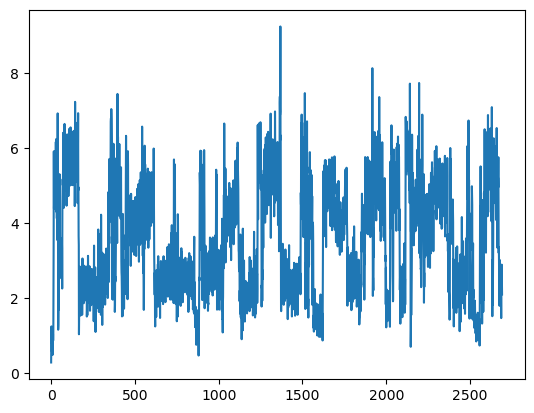

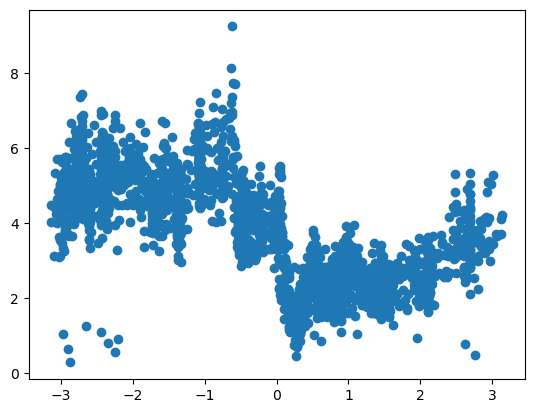

In [11]:
fig, ax= plt.subplots()
ax.plot(pp.timeseries['background'][-1,0,:])
fig, ax= plt.subplots()
heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()
ax.scatter(heading, pp.timeseries['background'][-1,0,:])

In [12]:
# y = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=False, background_ts='background')
y = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=True, background_ts='background')
# y = y-y.mean(axis=1,keepdims=True)
# y = pp.calculate_zscored_F('rois', exp_detrend=False, zscore=False, background_ts=None)
# y = pp.timeseries['rois']-pp.timeseries['background']
# y = (y-np.nanpercentile(y,5,axis=-1,keepdims=True))/np.nanpercentile(y,5,axis=-1,keepdims=True)
print(y.shape)

(1, 16, 2692)


In [13]:
pp.save()

In [14]:
if False:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    print(outdir)
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]
    heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()
    # print(pp.session_info)

(array([  2.,   3.,  16.,  34.,  45.,  75.,  71., 105., 156., 929., 881.,
        130.,  85.,  56.,  36.,  34.,  20.,   9.,   3.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

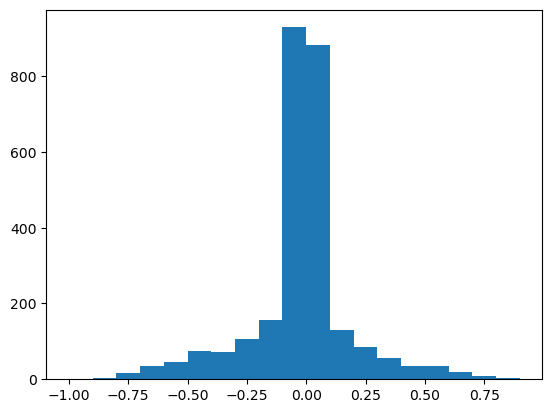

In [15]:
dh = np.angle(np.exp(1j*np.ediff1d(pp.voltage_recording_aligned[' Heading'].to_numpy(), to_end=0)))
fig, ax= plt.subplots()
ax.hist(dh, np.arange(-1,1,.1))

In [16]:


y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y, 2, axis=-1),.7,axis=1, mode='wrap')

# y_sm -= 
# y_sm = y-y.mean(axis=1,keepdims=True)
# y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y-1, 2, axis=-1),.7,axis=1, mode='wrap')
# y_sm = y-1



In [17]:
x_f,y_f = st2p.utilities.pol2cart(y_sm[-1,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
# print(rho.shape, phi.shape)



_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(1, 16, 2692) (2692,)


Text(0.5, 1.0, 'offset variance = 0.8211094793103332')

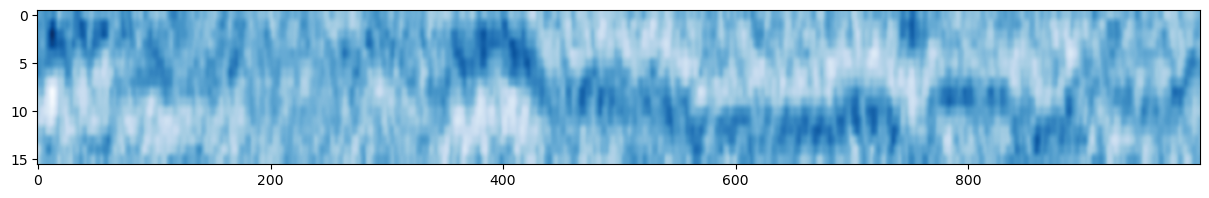

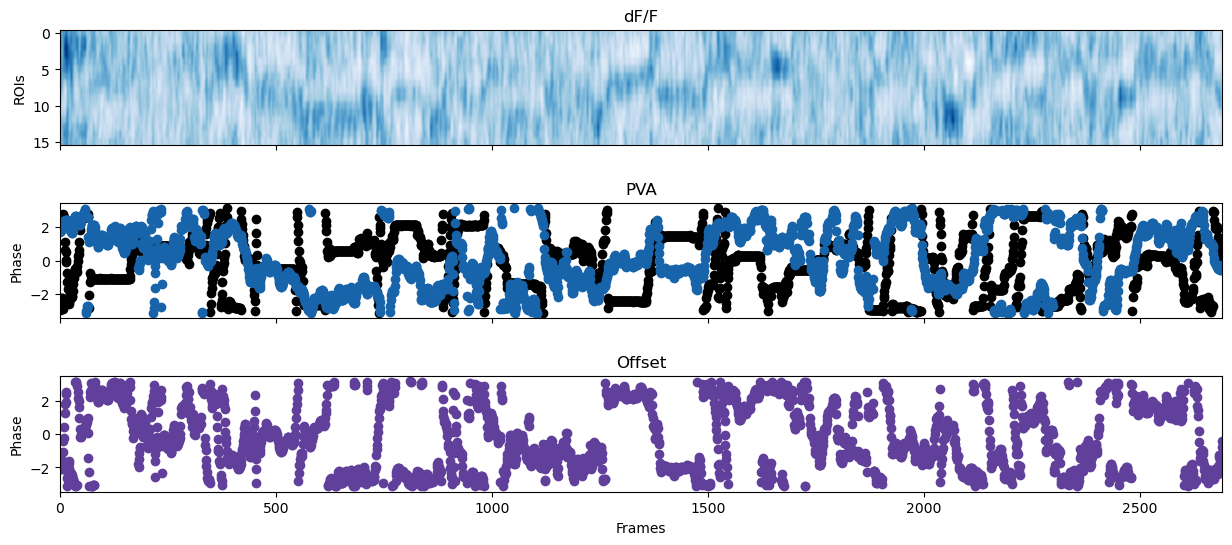

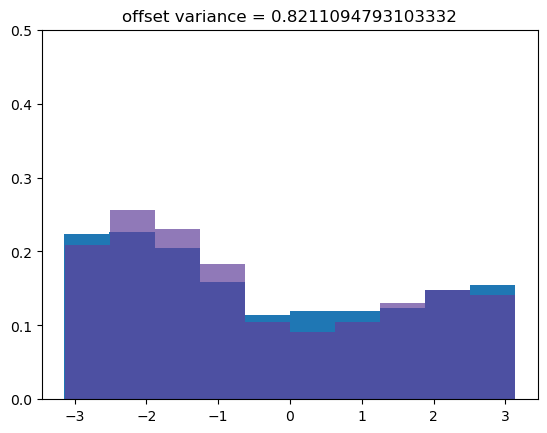

In [18]:
fig, ax= plt.subplots(1,1, figsize=[15,2], sharex=True)
fig.subplots_adjust(hspace=.5)
ax.imshow(y_sm[-1,::-1,0:1000]-y_sm[-1,:,:1000].mean(axis=0,keepdims=True), aspect='auto', cmap= 'Blues')#, vmin=-.3, vmax=.7)
# ax.scatter(np.arange(1000), (heading[:1000]+np.pi)/2/np.pi*15, color='red',s=3)

fig, ax= plt.subplots(3,1, figsize=[15,6], sharex=True)
fig.subplots_adjust(hspace=.5)
ax[0].imshow(y_sm[-1,::-1,:], aspect='auto', cmap= 'Blues')#,vmin=-.3, vmax=.3)
# ax[0].scatter(np.arange(y_sm.shape[-1]), (heading+np.pi)/2/np.pi*15, color='red',s=3)

# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[1].scatter(x,heading, color='black')
ax[1].scatter(x, phi, color=plt.cm.Blues(.8))
ax[2].scatter(x, offset, color=plt.cm.Purples(.8))
ax[0].set_ylabel('ROIs')
ax[0].set_title('dF/F')

ax[1].set_ylabel('Phase')
ax[1].set_title('PVA')

ax[2].set_ylabel('Phase')
ax[2].set_xlabel('Frames')
ax[2].set_title('Offset')



mask = ((heading<.5) | (heading>.5)) & (np.abs(dh)>.01) & (np.abs(dh)<.5)
# mask =  mask & (np.abs(dh)>.1) & 
# mask[:800]=False
fig, ax= plt.subplots()
ax.hist(offset[mask], density=True)
ax.hist(offset[800:][mask[800:]], alpha=.7, density=True, facecolor=plt.cm.Purples(.8))
ax.set_ylim([0,.5])
o = sp.stats.circvar(offset[mask])
ax.set_title(f'offset variance = {o}')

In [ ]:
heading_bins = np.linspace(-np.pi, np.pi, num=17)
heading_dig = np.digitize(heading, heading_bins)-1

y_h_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_h_aligned[0,:,ind] = np.roll(y_sm[-1,:,ind]-y_sm[-1,:,ind].mean(), -heading_dig[ind])
    
y_h_aligned_z = sp.stats.zscore(y_h_aligned, axis=1)
print(y_h_aligned_z.shape)

fig, ax = plt.subplots()
ax.imshow(y_h_aligned[0,:,:],aspect='auto',cmap='Greys')

fig, ax = plt.subplots()
ax.plot(y_h_aligned[0,:,:].mean(axis=-1))
mu, sem = y_h_aligned[0,:,:].mean(axis=-1), sp.stats.sem(y_h_aligned[0,:,:], axis=-1)
ax.fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3)
